# Moment Interaction Diagram

This example demonstrates how to generate moment interaction diagrams. We start by importing the necessary modules.

In [1]:
import numpy as np
from concreteproperties.material import Concrete, SteelBar
from concreteproperties.stress_strain_profile import (
    ConcreteLinear,
    RectangularStressBlock,
    SteelElasticPlastic,
)
from sectionproperties.pre.library.concrete_sections import concrete_rectangular_section
from concreteproperties.concrete_section import ConcreteSection
from concreteproperties.results import MomentInteractionResults

## Assign Materials
The materials used in this example will be 32 MPa concrete and 500 MPa steel, specified in accordance with AS 3600:2018.

In [2]:
concrete = Concrete(
    name="32 MPa Concrete",
    density=2.4e-6,
    stress_strain_profile=ConcreteLinear(elastic_modulus=30.1e3),
    ultimate_stress_strain_profile=RectangularStressBlock(
        compressive_strength=32,
        alpha=0.802,
        gamma=0.89,
        ultimate_strain=0.003,
    ),
    flexural_tensile_strength=3.4,
    colour="lightgrey",
)

steel = SteelBar(
    name="500 MPa Steel",
    density=7.85e-6,
    stress_strain_profile=SteelElasticPlastic(
        yield_strength=500,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="grey",
)

## Create Geometry and Concrete Section
The geometry used in this example is identical to that used in [Calculating Area Properties](area_properties.ipynb#Create-Geometry-and-Concrete-Section).

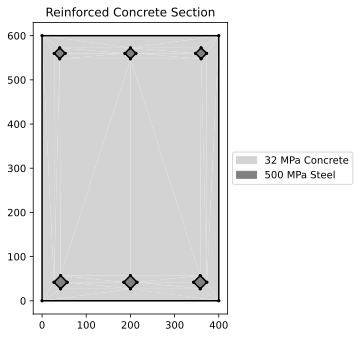

<AxesSubplot: title={'center': 'Reinforced Concrete Section'}>

In [3]:
geom = concrete_rectangular_section(
    b=400,
    d=600,
    dia_top=20,
    n_top=3,
    dia_bot=24,
    n_bot=3,
    n_circle=4,
    cover=30,
    area_top=310,
    area_bot=450,
    conc_mat=concrete,
    steel_mat=steel,
)

conc_sec = ConcreteSection(geom)
conc_sec.plot_section()

## Moment Interaction Diagram
We perform a moment interaction analysis by calling the ``moment_interaction_diagram()`` method.

In [4]:
mi_res = conc_sec.moment_interaction_diagram()

Output()

We can plot the moment interaction diagram by calling the ``plot_diagram()`` method.

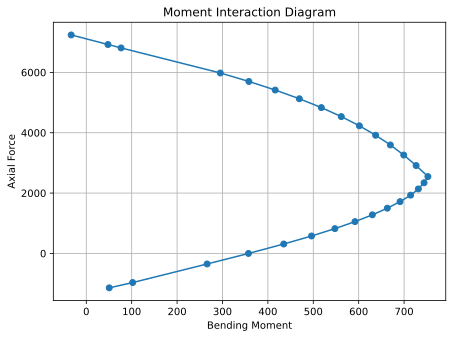

<AxesSubplot: title={'center': 'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [5]:
mi_res.plot_diagram()

What if we were interested in bending about the ``y`` axis? In this case the neutral axis angle would be $\theta = \pi / 2$. Let's generate a moment interaction diagram for this case. We must specify that the moments to plot are those about the ``y`` axis.

Output()

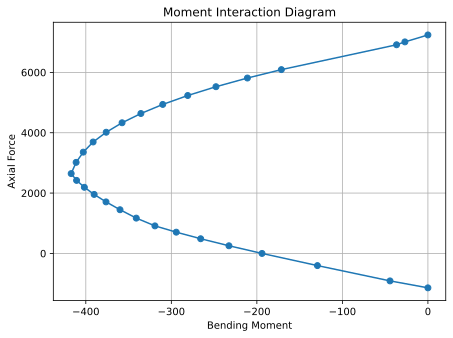

<AxesSubplot: title={'center': 'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [6]:
mi_res = conc_sec.moment_interaction_diagram(theta=np.pi / 2)
mi_res.plot_diagram(moment="m_y")

## Plotting Multiple Diagrams
We can also plot multiple diagrams at once by using the ``MomentInteractionResults.plot_multiple_diagrams()`` class method. In this example we'll create four different reinforced concrete cross-sections with different reinforcement ratios.

In [7]:
# create lists to hold results and labels
mi_results = []
labels = []

# create four different sections with increasing reinforcement
# and peform a moment interaction analysis
for idx in range(4):
    geom = concrete_rectangular_section(
        b=400,
        d=600,
        dia_top=16,
        n_top=6,
        dia_bot=16,
        n_bot=6,
        n_circle=4,
        cover=66,
        area_top=200 * (idx + 1),
        area_bot=200 * (idx + 1),
        conc_mat=concrete,
        steel_mat=steel,
    )

    conc_sec = ConcreteSection(geom)
    mi_results.append(conc_sec.moment_interaction_diagram())
    labels.append("p = {0}".format(0.01 * (idx + 1)))

Output()

Output()

Output()

Output()

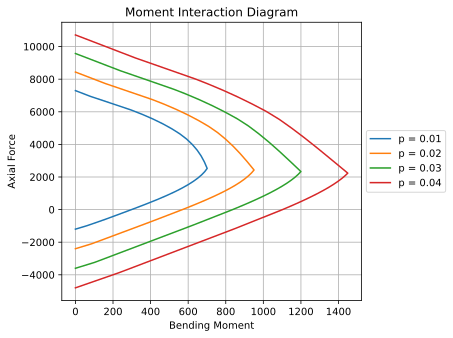

<AxesSubplot: title={'center': 'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [8]:
# plot all the diagrams on one image
MomentInteractionResults.plot_multiple_diagrams(
    moment_interaction_results=mi_results, labels=labels, fmt="-"
)

## Positive & Negative Interaction Diagrams
We can combine positive and negative bending on one plot using the ``plot_multiple_diagrams()`` method. Here we genearte results for ``theta = 0`` and ``theta = np.pi`` and plot both diagrams.

Output()

Output()

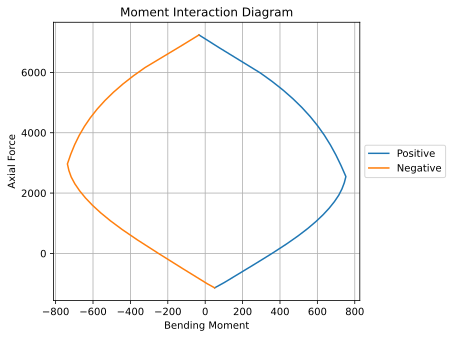

<AxesSubplot: title={'center': 'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [9]:
geom = concrete_rectangular_section(
    b=400,
    d=600,
    dia_top=20,
    n_top=3,
    dia_bot=24,
    n_bot=3,
    n_circle=4,
    cover=30,
    area_top=310,
    area_bot=450,
    conc_mat=concrete,
    steel_mat=steel,
)
conc_sec = ConcreteSection(geom)

mi_res_pos = conc_sec.moment_interaction_diagram()
mi_res_neg = conc_sec.moment_interaction_diagram(theta=np.pi)

MomentInteractionResults.plot_multiple_diagrams(
    moment_interaction_results=[mi_res_pos, mi_res_neg],
    labels=["Positive", "Negative"],
    fmt="-",
)

In the above plot the bending capacity is higher for positive bending and not symmetric. This is because the bottom bars (3N24) provide more area than the top bars (3N20).

## Advanced Features
This section will describe some advanced features that can be used to control how the moment interaction diagram is generated and displayed.

1. ``control_points`` - adding control points to the moment interaction diagram allows the user to ensure certain points are captured on the moment interaction diagram. Control points are defined as a list of (``str``, ``float``) tuples. The default argument for ``control_points`` is ``[("D", 1.0), ("fy", 1.0), ("N", 0.0)]`` which produces control points at the decompression point, the balanced point and the pure bending point. Types of acceptable control points are:<br>
    a. ``D`` - ratio of neutral axis depth to section depth, e.g. the (``"D"``, ``0.5``) control point will ensure a neutral axis at mid-depth is analysed.<br>
    b. ``d_n`` - neutral axis depth, e.g. the (``"d_n"``, ``200``) control point will ensure a netural axis at 200 is analysed.<br>
    c. ``fy`` - yield ratio of the most extreme tensile bar, e.g. the (``"fy"``, ``0.5``) control point will ensure a neutral axis corresponding to a strain of half the yield strain in the extreme tensile bar is analysed. The (``"fy"``, ``1.0``) control point is the balanced point.<br>
    d. ``N`` - axial force, e.g. (``"N"``, ``3000e3``) ensures a neutral axis depth corresponding to a net axial force of 3000e3 is analysed.<br>
    e. ``kappa_0`` - zero curvature compression, this must be at start of the list as it results in the largest compression force. Note that the second value in the tuple is not used and can be anything.<br>

2. ``labels`` - A list of labels to apply to the ``control_points`` for plotting purposes.
3. ``n_points`` - The number of neutral axis depths to compute between each control point.
3. ``max_comp`` - Limits the maximum compressive force in the moment interaction diagram by cutting off the top of the diagram.

The below example will use all these features, creating additional control points at zero strain, 50% strain and a neutral axis depth of 200 mm. Note, care must be taken to ensure that the ``control_points`` are ordered from largest neutral axis depth to smallest neutral axis depth otherwise a ``ValueError`` will be raised. Labels are applied and the number of points between each control point is modified. A maximum compressive force of 6800 kN is provided.

In [10]:
mi_res = conc_sec.moment_interaction_diagram(
    control_points=[
        ("kappa0", 0),
        ("D", 1.0),
        ("fy", 0),
        ("fy", 0.5),
        ("fy", 1.0),
        ("d_n", 200),
        ("N", 0.0),
        ("d_n", 1e-6),
    ],
    labels=["NA", "C", "D", "E", "F", "G", "H", "I"],
    n_points=[3, 3, 8, 8, 8, 12, 8],
    max_comp=6.8e6,
    max_comp_labels=["A", "B"],
)

Output()

To display the labels set ``labels=True``. The argument ``label_offset`` attempts to offset the labels from the diagram in a pretty way.

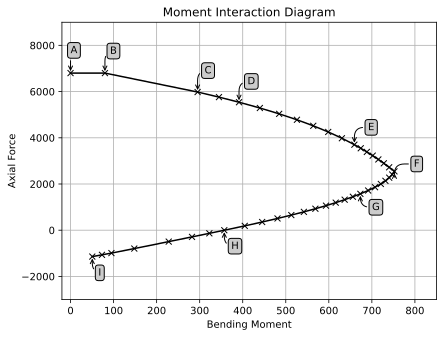

In [11]:
ax = mi_res.plot_diagram(fmt="-kx", labels=True, label_offset=True, render=False)

# reset axis limits to ensure labels are within plot
import matplotlib.pyplot as plt

ax.set_xlim(-20, 850)
ax.set_ylim(-3000, 9000)
plt.show()